In [5]:
# imports
from skimage.exposure import rescale_intensity
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import feature
plt.rcParams['figure.figsize'] = (20, 10)


In [6]:
def show_image(image, grey=False):
    if grey:
        plt.imshow(image,cmap='gray', vmin = 0, vmax = 255)
    else:
        plt.imshow(image)

    plt.show()

# Local Binary Patterns
LBP looks at points surrounding a central point and tests whether the surrounding points are greater than or less than the central point (i.e. gives a binary result).

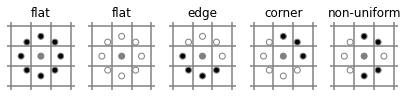

In [7]:

def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)
        

            


    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

When using LBP to detect texture, you measure a collection of LBPs over an image patch and look at the distribution of these LBPs. Lets apply LBP to a brick texture.

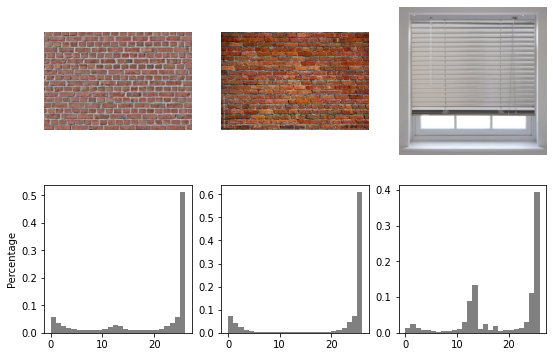

In [14]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
from skimage import io
from skimage.color import rgb2gray

# settings for LBP
radius = 3
n_points = 8 * radius
METHOD = 'uniform'


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


bricks1 = io.imread('data/bricks1.jpeg')
bricks1_grey = rgb2gray(bricks1)
lbp1 = local_binary_pattern(bricks1_grey, n_points, radius, METHOD)

bricks2 = io.imread('data/bricks2.jpg')
bricks2_grey = rgb2gray(bricks2)
lbp2 = local_binary_pattern(bricks2_grey, n_points, radius, METHOD)



blinds1 = io.imread('data/blinds1.jpg')
blinds1_grey = rgb2gray(blinds1)
lbp3 = local_binary_pattern(blinds1_grey, n_points, radius, METHOD)

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()


ax_img[0].imshow(bricks1)
ax_img[1].imshow(bricks2)
ax_img[2].imshow(blinds1)


hist(ax_hist[0],lbp1)
hist(ax_hist[1],lbp2)
hist(ax_hist[2],lbp3)





ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Harris Corner Detection
it basically finds the difference in intensity for a displacement of (u,v) in all directions. This is expressed as below:
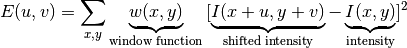
It can be represented in a nice picture as follows:
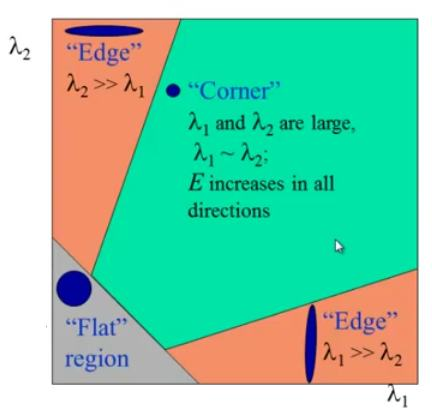

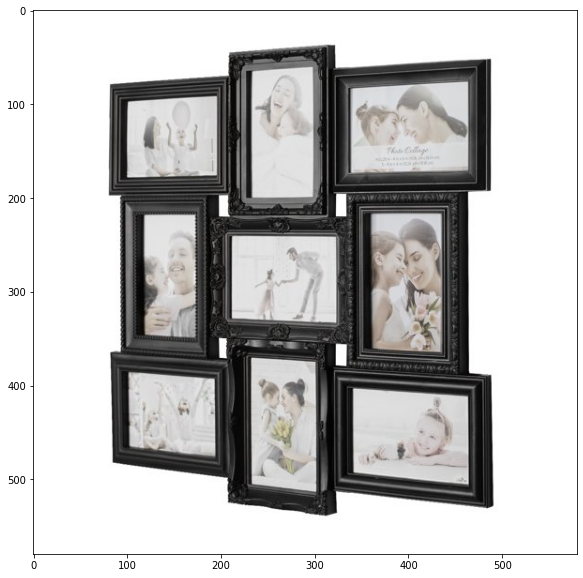

In [15]:
edges_image = cv2.imread('data/edges.jpeg')
edges_image = cv2.cvtColor(edges_image, cv2.COLOR_BGR2RGB)
show_image(edges_image)

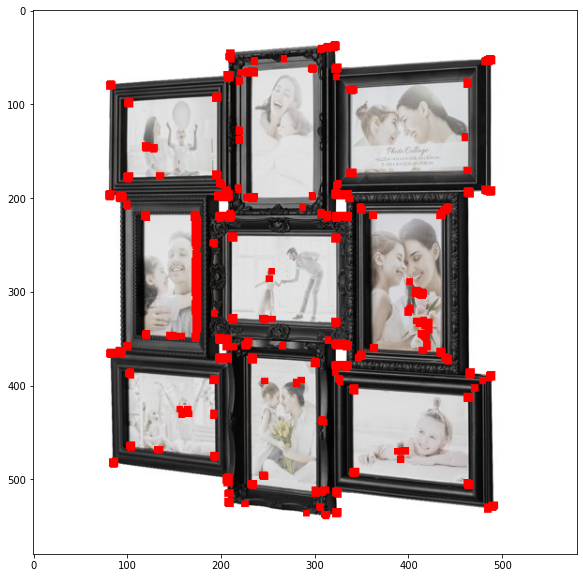

In [17]:
# convert to grey scale for harris
edges_image_gray = cv2.cvtColor(edges_image,cv2.COLOR_BGR2GRAY)

# apply harris corner detector
# blockSize - It is the size of neighbourhood considered for corner detection
# ksize - Aperture parameter of the Sobel derivative used.   size of the extended Sobel kernel; it must be 1, 3, 5, or 7. 
# k - Harris detector free parameter in the equation.
corners = cv2.cornerHarris(edges_image_gray,2,3,0.04)

# enhance the corners for visualization
corners = cv2.dilate(corners,None,iterations=3)
display_image1 = edges_image.copy()
# color the image at the corners
display_image1[corners>0.01*corners.max()]=[255,0,0]

show_image(display_image1)

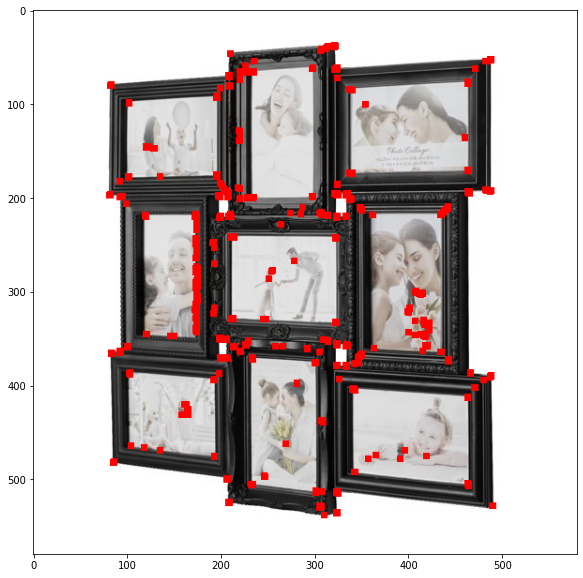

In [27]:
# convert to grey scale for harris
edges_image_gray = cv2.cvtColor(edges_image,cv2.COLOR_BGR2GRAY)

# apply harris corner detector
corners = cv2.cornerHarris(edges_image_gray,2,3,0.06)

# enhance the corners for visualization
corners = cv2.dilate(corners,None,iterations=3)
display_image2 = edges_image.copy()
# color the image at the corners
display_image2[corners>0.01*corners.max()]=[255,0,0]

show_image(display_image2)

# Feature Descriptors

## HOG

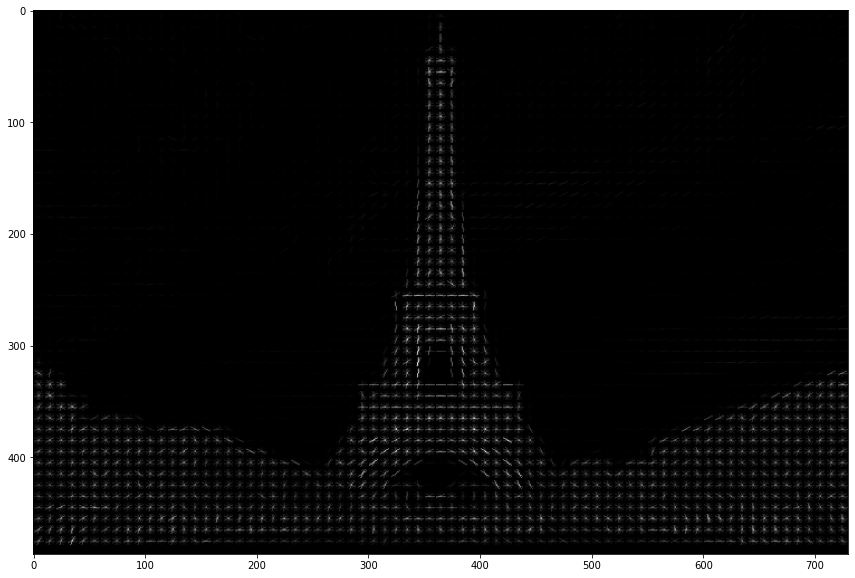

In [34]:
tower_image = cv2.imread('data/tower1.jpg')
tower_image_grey = cv2.cvtColor(tower_image, cv2.COLOR_BGR2RGB)
H, hogImage = feature.hog(tower_image_grey, orientations=9, pixels_per_cell=(10, 10),cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
show_image(hogImage)

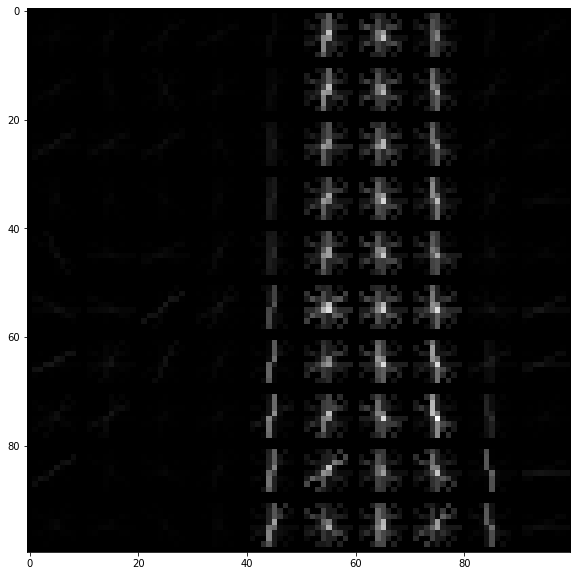

In [35]:
show_image(hogImage[100:200,300:400])


## SIFT (Scale-Invariant Feature Transform)
A corner may not be a corner if the image is scaled. For example, check a simple image below. A corner in a small image within a small window is flat when it is zoomed in the same window. So Harris corner is not scale invariant.
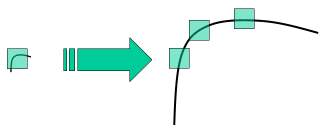
There are mainly four steps involved in SIFT algorithm
1. Scale-space Extrema Detection
We use scale-space filtering with various values for parameters in caluclating  Laplacian of Gaussian which acts as a blob detector.
2. Keypoint Localization
Once potential keypoints locations are found, they have to be refined to get more accurate results. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. 
3. Orientation Assignment
Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neigbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region
4. Keypoint Descriptor
Now keypoint descriptor is created. A 16x16 neighbourhood around the keypoint is taken. It is devided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. It is represented as a vector to form keypoint descriptor. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation etc.

5. Keypoint Matching
Keypoints between two images are matched by identifying their nearest neighbours. But in some cases, the second closest-match may be very near to the first. It may happen due to noise or some other reasons. In that case, ratio of closest-distance to second-closest distance is taken. If it is greater than 0.8, they are rejected. It eliminaters around 90% of false matches while discards only 5% correct matches, as per the paper.

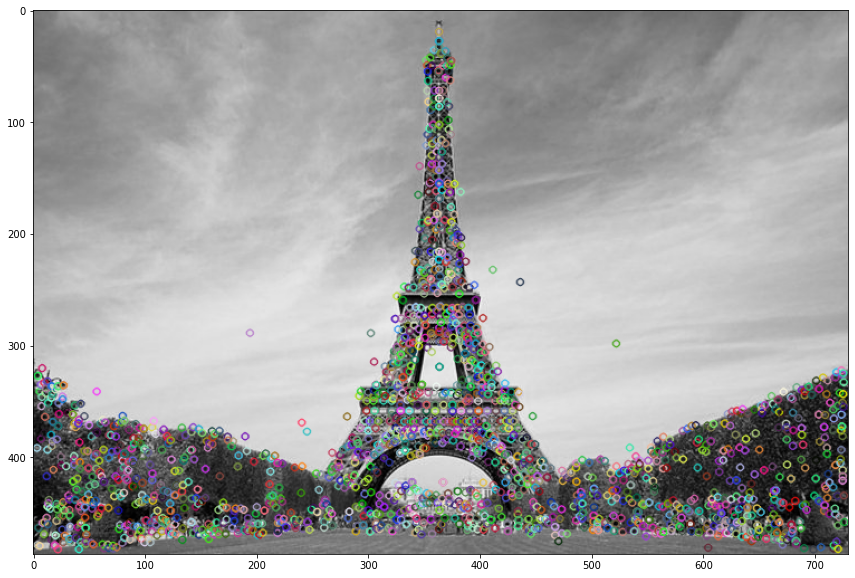

In [59]:
edges_image = cv2.imread('data/tower1.jpg')
edges_image = cv2.cvtColor(edges_image, cv2.COLOR_BGR2RGB)
edges_image_gray = cv2.cvtColor(edges_image,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(edges_image_gray,None)
img=cv2.drawKeypoints(edges_image_gray,kp,edges_image)
show_image(img)

## Feature matching

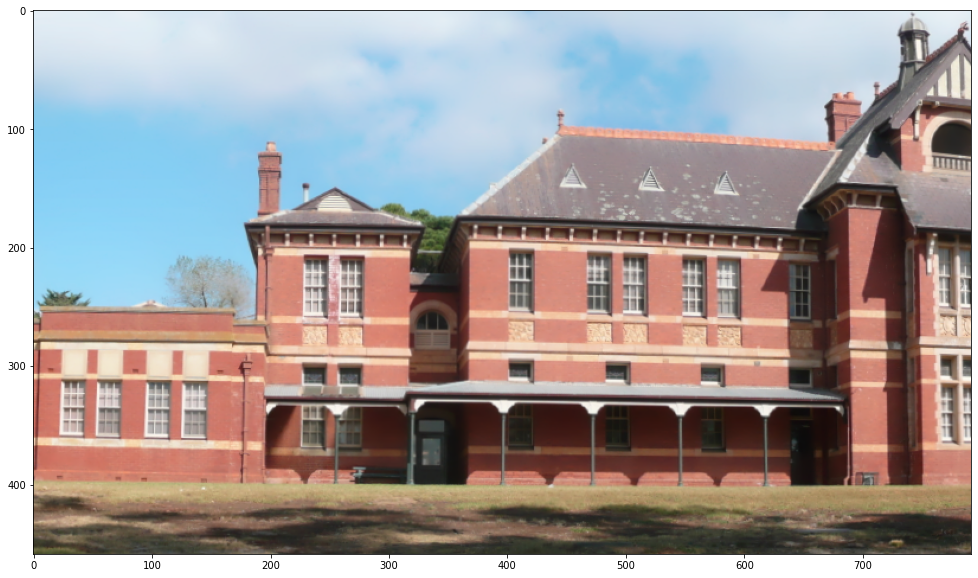

In [43]:
img1 = cv2.cvtColor(cv2.imread('data/stitch1.png'), cv2.COLOR_BGR2RGB)          # queryImage
show_image(img1)

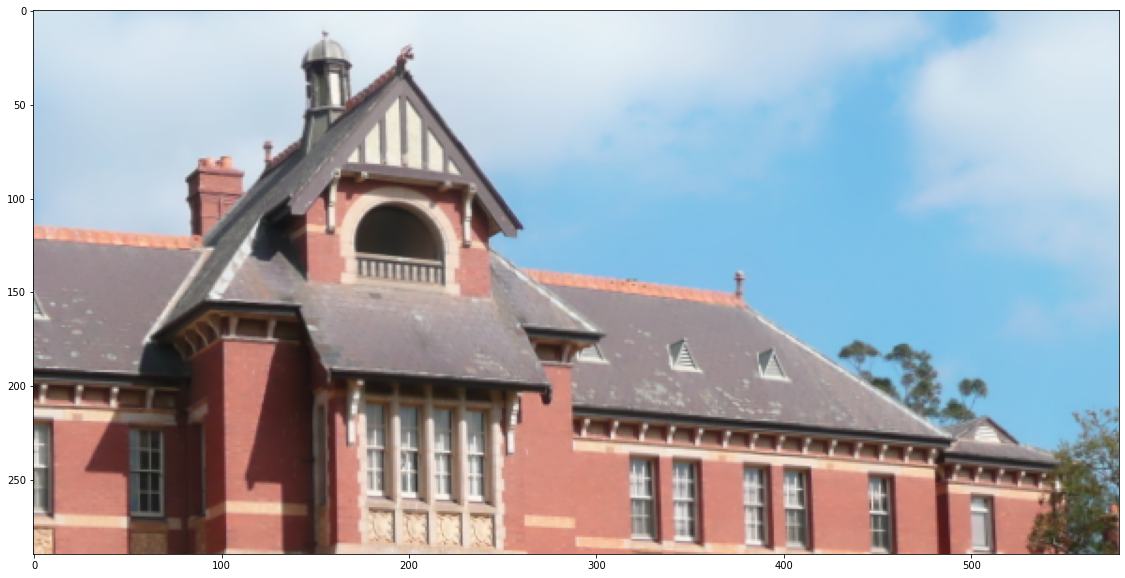

In [44]:
img2 = cv2.cvtColor(cv2.imread('data/stitch2.png'), cv2.COLOR_BGR2RGB)   
show_image(img2)# queryImage

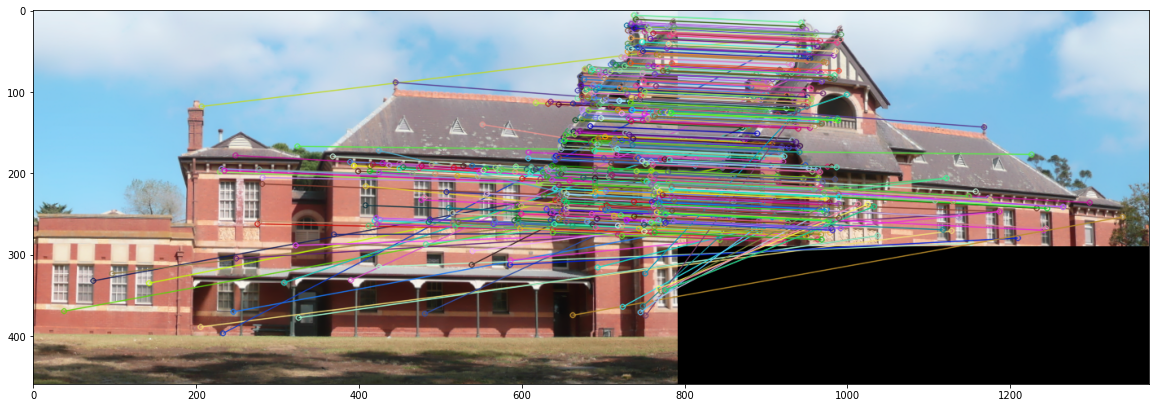

(<matplotlib.image.AxesImage at 0x7f19500d2668>, None)

In [45]:

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1_gray,None)
kp2, des2 = sift.detectAndCompute(img2_gray,None)

# BFMatcher with default params
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)



# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img3),plt.show()

In [46]:
n.distance

380.118408203125

In [47]:
# calculate homography
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
M

array([[ 9.99839381e-01,  2.39309959e-05, -5.86911684e+02],
       [-8.07454265e-05,  9.99974168e-01,  9.03051628e+00],
       [-3.96964526e-07,  6.19149171e-07,  1.00000000e+00]])

In [53]:
# stitch images
def stitch_images(img_left, img_right, H):
    # Change the angle of view to the right of the picture, result is the transformed picture
    result = cv2.warpPerspective(img_right, H, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
    # Pass the picture left to the left end of the result picture
    result[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
    return result
stitched = stitch_images(img2,img1, M)

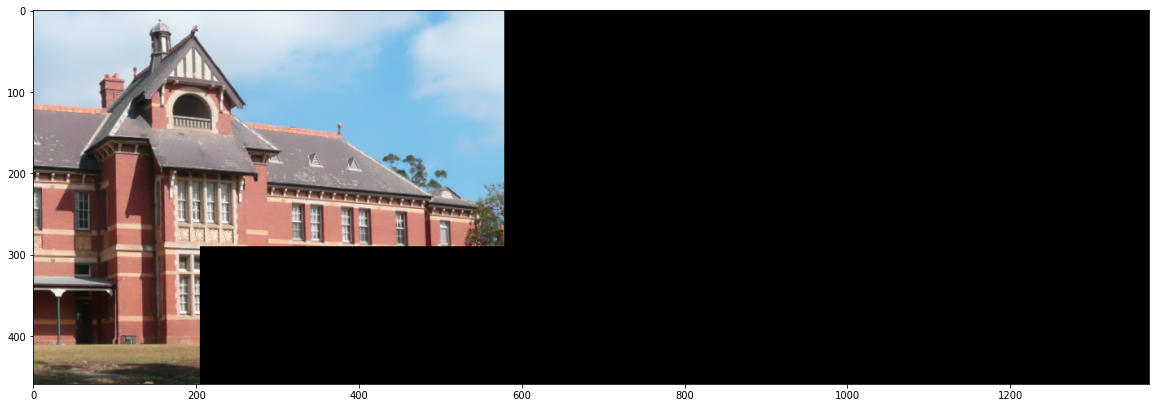

In [54]:
show_image(stitched)